In [2]:
%cd ../

/home/gramos/Projects/MIIA-A23/code/mercury-duckling


/home/gramos/.pyenv/versions/3.11.5/envs/thermal/lib/python3.11/site-packages/IPython/core/magics/osm.py:417: UserWarning: using dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [3]:
import numpy as np
from PIL import Image
from torchvision.transforms import Compose
from mercury_duckling.datasets.transforms import (
    Blobify,
    OneHotEncodeFromBlobs,
    Colormap,
)
from mercury_duckling.datasets import ThermalDataset

In [8]:
transform = Compose([
    Colormap("Greys"),
    # ToTensor()
])
target_transform = Compose([
    Blobify(),
    OneHotEncodeFromBlobs(),
    # ToTensor()
])
both_transform = None
dataset = ThermalDataset(
    root="../../data/_500_per_folder/merged_dataset_delam",
    annFile="delamination.json",
    transform=transform,
    target_transform=target_transform,
    both_transform=both_transform,
)

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


In [9]:
input, target, path = dataset[0]
print("path:", path)
print(
    "input shape:", input.shape, 
    "input class:", type(input),
    "input dtype:", input.dtype
)
print(
    "target shape:", target.shape,
    "target class:", type(target),
    "target dtype:", target.dtype
)

path: ../../data/_500_per_folder/merged_dataset_delam/images/delamination/IR08_1.jpg
input shape: (240, 320, 3) input class: <class 'numpy.ndarray'> input dtype: float64
target shape: (240, 320, 2) target class: <class 'numpy.ndarray'> target dtype: uint8


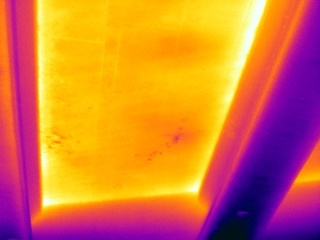

In [6]:
display(Image.open(path))

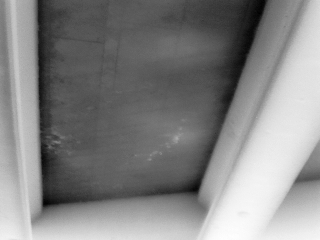

In [10]:
display(Image.fromarray((input*255).astype(np.uint8)))